# Non-parametric deprojection and mass reconstruction

Observed galaxy cluster profiles are _projected_ realizations of the true 3D cluster properties convolved with instrumental effects, in particular with the telescope's point spread function (PSF). The projection and PSF convolution process is lossy, thus the inverse procedure amplifies noise and direct deprojection of thermodynamic profiles creates very noisy profiles. 

To alleviate this issue, we recently introduced a non-parametric approach to deprojection and PSF deconvolution based on the decomposition of 3D profiles onto a basis of functions. Namely, we set a dictionary of functions $\{\Phi_i\}_{i=1}^P$ and we assume that the true profile can be written down as a linear combination of the basis functions,

$$ X_{3D} = \sum_{i=1}^P N_i \Phi_i $$

with X the thermodynamic quantity of interest and $\{N_i\}_{i=1}^P$ the set of coefficients of each function. Since the convolution and PSF convolution process is linear, the individual basis functions can be individually projected and fitted directly onto the projected data. The relation between the 3D normalization and its projected counterpart can also be worked out analytically. 

_hydromass_ and _pyproffit_ include an implementation of this technique for the specific case of galaxy cluster profiles. The model includes deprojection, PSF deconvolution, and spectroscopic-like temperature weights. This tutorial explains how to use the two packages to extract non-parametric 3D profiles of the relevant thermodyanamic quantities (gas density, temperature, pressure, and entropy) and of the hydrostatic mass profile and gas fraction.


In [1]:
import numpy as np

import pyproffit

import hydromass

import matplotlib.pyplot as plt


Here we reload the surface brightness profile of the test cluster MACS 0451. To extract it again see [the tutorial on mass profiles](https://hydromass.readthedocs.io/en/latest/Mass_model.html).

In [2]:
datv, p2 = pyproffit.Reload('../../test_data/sb_pyproffit.fits')

DATA structure found
Corresponding pixels coordinates:  428.00000000000836 416.0000000000049
PSF structure found


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 53265.507373 from DATE-END'. [astropy.wcs.wcs]


Let's have a look at the reloaded profile...

<Figure size 936x720 with 0 Axes>

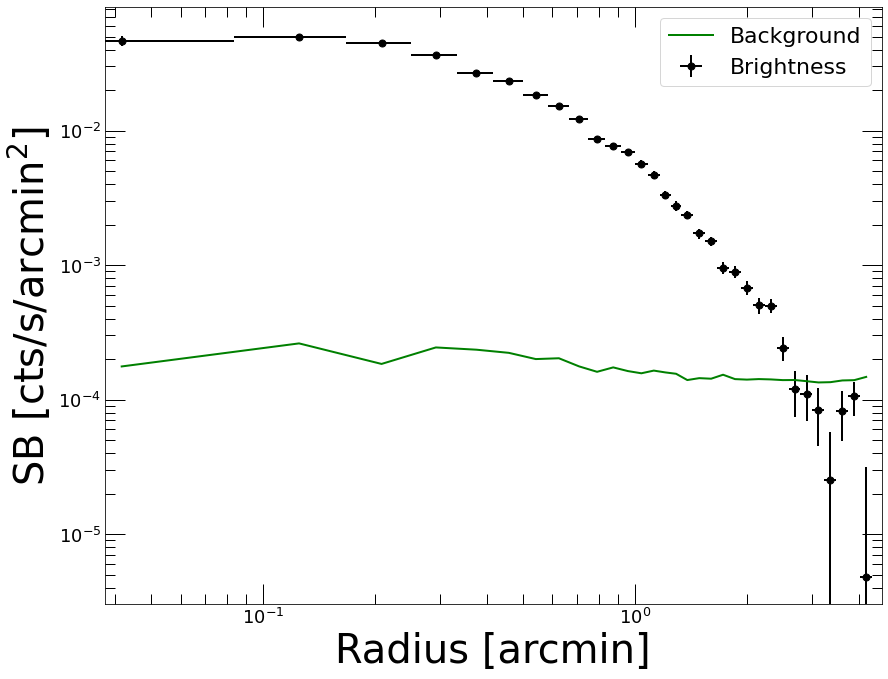

In [3]:
p2.Plot()

## Loading the data ##

We start by loading the spectral fitting results for MACS 0451 into a [hydromass.SpecData](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.tpdata.SpecData) structure. We also compute a PSF mixing matrix appropriate for XMM-Newton data


In [4]:
z_m0451 = 0.5398 # Source redshift
nh_m0451 = 0.0454 # Galactic NH

rsp = '/Users/deckert/Documents/Work/devel/hydromass/test_data/m1.rsp' # on-axis response file

spec_data = hydromass.SpecData(redshift=z_m0451,
                               spec_data='../../test_data/spectral_results_MACS0451.fits')

def fking(x):
    r0=0.0883981
    alpha=1.58918
    return np.power(1.+(x/r0)**2,-alpha)

spec_data.PSF(pixsize=2.5/60., psffunc=fking)


Reading spectral data from file ../../test_data/spectral_results_MACS0451.fits


We are now ready to define a [hydromass.Mhyd](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd) object, which will specify the data to be used and the parameters of the source

In [5]:
mhydNP = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451)


No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


We also need to compute the conversion between count rate and emissivity, which can be done easily using the [emissivity](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.emissivity) method of the Mhyd class. Note that this function requires XSPEC to be available in PATH. See [the tutorial on mass profiles](https://hydromass.readthedocs.io/en/latest/Mass_model.html) for more details.

In [ ]:
mhydNP.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)


In [7]:
print('Conversion between count rate and emission measure: ', mhydNP.ccf)

Conversion between count rate and emission measure:  21.22


## Running the code ##

We are now ready to run the non-parametric reconstruction. This is achieved through the [run_GP](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.run_GP) method of the Mhyd class. The main parameters of the reconstruction are the smoothing scales of the log-normal mixture model. The temperature profile is described as a linear combination of a large number of log-normal functions, 

$$ T_{NP}(r)=\sum_{i=1}^{N_g} G_i \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{(\ln(r)-\ln(\mu_i))^2}{2\sigma_i^2}\right) $$

with the mean values $\{\mu_i\}_{i=1}^{N_g}$ of the log-normals adaptively set between the core and the outskirts. The standard deviations $\{\sigma_i\}_{i=1}^{N_g}$ act as effective smoothing scales, with larger values of $\sigma$ corresponding to a higher level of smoothing and lower values increasing the fidelity of the reconstruction with respect to the actual data.

The level of smoothing can be set in two ways: either adaptively or manually. In the adaptive case (default), the smoothing scale is set to the width of the loaded spectroscopic bins, such that fluctuations smaller than the bin width are killed and fluctuations on larger scales are permitted. The _bin_fact_ parameter allows the user to tune the size of the smoothing scale with respect to the bin size. For instance, setting _bin_fact=2.0_ will increase the adaptive smoothing scale to twice the bin size. 

Alternatively, the user can provide custom values _smin_ and _smax_ of the smoothing scales (in arcmin). In this case, the values of $\{\sigma_i\}_{i=1}^{N_g}$ will be logarithmically spaced from _smin_ in the core to _smax_ in the outskirts.

In the following example we explicitly set the default parameters of the non-parametric model, i.e. we use adaptive smoothing with _bin_fact_=1 (i.e. set to the width of the bins) and $N_g=100$. This is equivalent to running the [run_GP](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.run_GP) method with no argument.

In [8]:
mhydNP.run_GP(nmcmc=200,
             tune=200,
             bin_fact=1.0,
             smin=None,
             smax=None,
             ngauss=100)

Single conversion factor provided, we will assume it is constant throughout the radial range
coefs -187.90419872441586
GP -391.4670806758654
Running MCMC...


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/hydromass/nonparametric.py:1129: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(nmcmc, start=start, tune=tune)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GP, coefs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 18 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Done.
 Total computing time is:  0.3832083503405253  minutes


## Inspecting the results ##

We can inspect the fit by comparing the fitted profiles and its uncertainty to the data

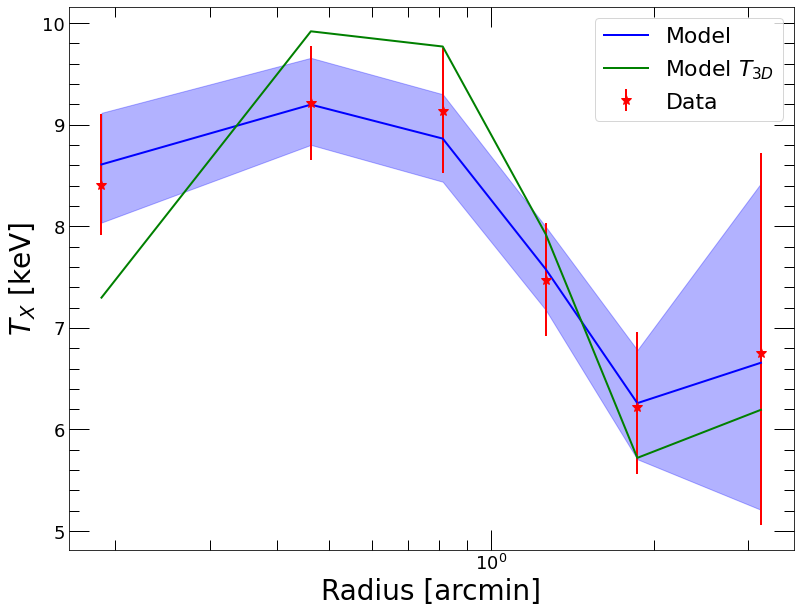

In [9]:
plt.clf()

plt.xscale('log')
    
plt.xlabel('Radius [arcmin]')
plt.ylabel('$T_{X}$ [keV]')
plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,mhydNP.ktmod,color='blue', label='Model')
plt.fill_between(spec_data.rref_x_am, mhydNP.ktmod_lo, mhydNP.ktmod_hi, color='blue', alpha=0.3)
plt.plot(spec_data.rref_x_am,mhydNP.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)


As we can see, the projected model (here in blue) follows the data very closely. That is by design, as we have set the smoothing to the bare minimum, i.e. only fluctuations smaller than the bin size are removed. The 1-sigma error envelopes of the posterior temperature distributions at each radius are very similar to the actual statistical uncertainties, indicating that our model truly is non-parametric and does not force any additional constraint on the data. 

We can also have a look at the fitted surface brightness model, which is decomposed into a linear combination of King functions (see [Eckert et al. 2020](https://ui.adsabs.harvard.edu/abs/2020OJAp....3E..12E/abstract)),

<Figure size 936x720 with 0 Axes>

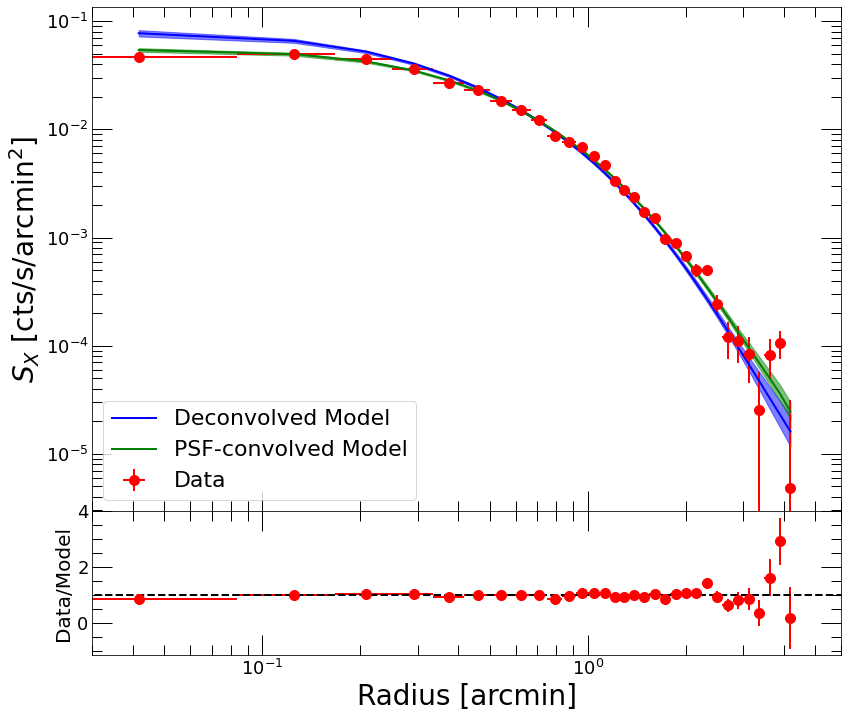

In [10]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax=fig.add_axes([0.12,0.3,0.8,0.7])
ax_res=fig.add_axes([0.12,0.1,0.8,0.2])

ax.set_yscale('log')
ax.set_xscale('log')
ax_res.set_xscale('log')
ax_res.set_xlabel('Radius [arcmin]')
ax_res.set_ylabel('Data/Model', fontsize=20)
ax.set_ylabel('$S_{X}$ [cts/s/arcmin$^2$]')

ax.plot(p2.bins, mhydNP.sb_dec, color='blue', label='Deconvolved Model')
ax.fill_between(p2.bins, mhydNP.sb_dec_lo, mhydNP.sb_dec_hi, color='blue', alpha=0.5)
ax.errorbar(p2.bins, p2.profile, xerr=p2.ebins, yerr=p2.eprof, fmt='o', color='red', label='Data')


ax.plot(p2.bins, mhydNP.sb, color='green', label='PSF-convolved Model')
ax.fill_between(p2.bins, mhydNP.sb_lo, mhydNP.sb_hi, color='green', alpha=0.5)

ax.set_xlim(3e-2, 6)

ax.legend(fontsize=22)

resid = p2.profile / mhydNP.sb
err_resid = p2.eprof / mhydNP.sb
ax_res.errorbar(p2.bins, resid, xerr=p2.ebins, yerr=err_resid, fmt='o', color='red')

ax_res.set_xlim(3e-2, 6.)

ax_res.plot(np.linspace(1e-2, 9., 100), np.ones(100), '--', color='black')


Again the model is doing an excellent job at reproducing the observed profile shape at every radii. The effect of PSF deconvolution can be clearly seen in the cluster core, where the PSF deconvolved profile substantially exceeds the data. PSF deconvolution also leads to a slightly steeper radial profile in the outskirts.

## Thermodynamic and cooling time profiles ##

The posterior 3D models of gas emissivity and temperature can then be combined to reconstruct radial profiles of the main thermodynamic quantities. This is achieved easily using the [hydromass.prof_gp_hires](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.nonparametric.prof_GP_hires) function, which allows the user to extract 3D profiles in any user-defined radial range.

To estimate the radiative cooling time, _hydromass_ includes tabulated values of the bolometric cooling function computed using the APEC model, as a function of the gas temperature and metallicity. The cooling function profile is drawn from the temperature profile for a (constant) input metal abundance that can be tuned by the user.

In [11]:
thermo_profiles = hydromass.prof_GP_hires(Mhyd=mhydNP,
                                          npt=200,
                                          rin=40.,
                                          Z=0.3)

The resulting object is a dictionary containing a number of output 3D radial profiles,

In [12]:
thermo_profiles.keys()

dict_keys(['R_IN', 'R_OUT', 'R_REF', 'P_TOT', 'P_TOT_LO', 'P_TOT_HI', 'T3D', 'T3D_LO', 'T3D_HI', 'TSPEC', 'TSPEC_LO', 'TSPEC_HI', 'NE', 'NE_LO', 'NE_HI', 'K', 'K_LO', 'K_HI', 'T_COOL', 'T_COOL_LO', 'T_COOL_HI', 'LAMBDA', 'LAMBDA_LO', 'LAMBDA_HI'])

For instance let's have a look at the output pressure profile and compare it with the "pseudo-pressure" obtained by multiplying the 3D gas density with the spectroscopic temperature,

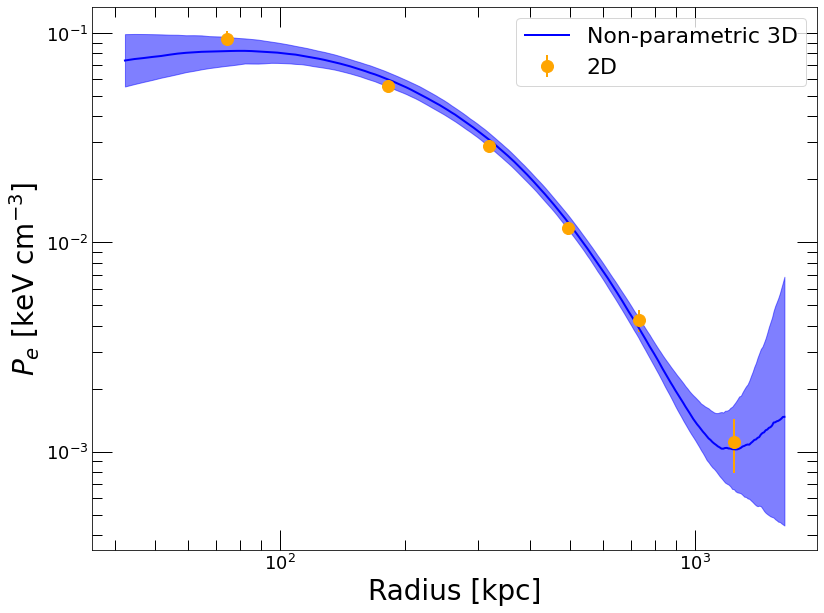

In [13]:
plt.clf()

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$P_{e}$ [keV cm$^{-3}$]', fontsize=28)

plt.plot(thermo_profiles['R_OUT'], thermo_profiles['P_TOT'], color='blue', label='Non-parametric 3D')
plt.fill_between(thermo_profiles['R_OUT'], thermo_profiles['P_TOT_LO'], thermo_profiles['P_TOT_HI'], color='blue', alpha=0.5)

pvals = np.interp(spec_data.rref_x, thermo_profiles['R_OUT'], thermo_profiles['NE']) * spec_data.temp_x
epvals = np.interp(spec_data.rref_x, thermo_profiles['R_OUT'], thermo_profiles['NE']) * spec_data.temph

plt.errorbar(spec_data.rref_x, pvals, yerr=epvals, fmt='o', color='orange', markersize=12, label='2D')

plt.legend(fontsize=22)


The model provides a very good approximation of the pressure profile in-between the data points but it clearly cannot be extrapolated beyond the fitted range, which makes sense since the linear combination of functions is unconstrained beyond the outermost data point and below the innermost one. In a similar way, by design the pressure gradient is unconstrained at the two boundaries, such that the hydrostatic mass cannot be computed there. 

We can also have a look at the radiative cooling time, defined as the ratio of thermal energy to cooling efficiency,

$$ t_{cool} = \frac{3/2 (n_e + n_H) k T}{\Lambda n_e n_H} $$

with $\Lambda$ the bolometric cooling function

<Figure size 936x720 with 0 Axes>

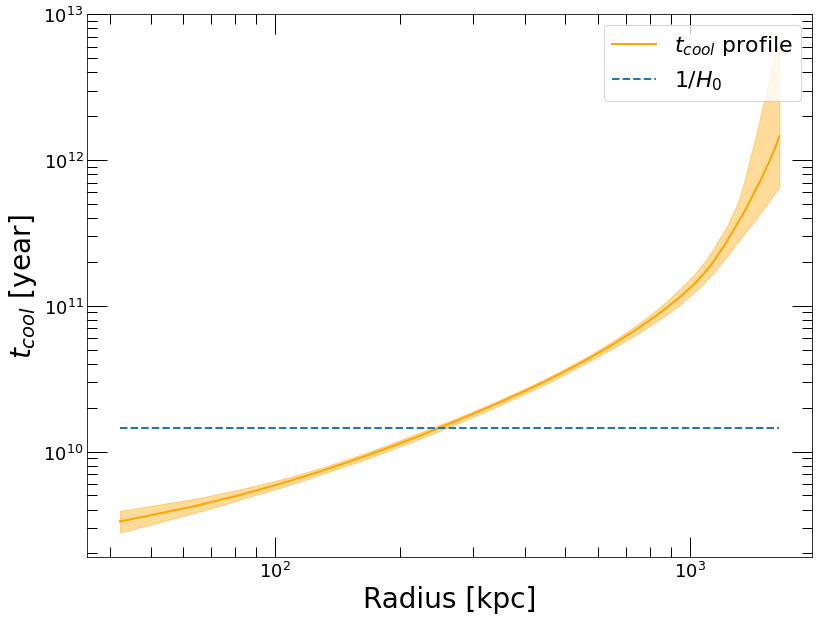

In [14]:
plt.clf()

fig = plt.figure()
ax = fig.add_subplot()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('$t_{cool}$ [year]')    

plt.plot(thermo_profiles['R_OUT'], thermo_profiles['T_COOL'], color='orange', label='$t_{cool}$ profile')
plt.fill_between(thermo_profiles['R_OUT'], thermo_profiles['T_COOL_LO'], thermo_profiles['T_COOL_HI'], color='orange', alpha=0.4)

ylim = ax.get_ylim()
xlim = ax.get_xlim()

thubble = 1. / (pyproffit.cosmo.H0.value * 1e5 / hydromass.constants.cgsMpc) / hydromass.year

plt.plot(thermo_profiles['R_OUT'], np.ones(len(thermo_profiles['R_OUT']))*thubble, '--', label='$1/H_0$')

plt.axis([xlim[0],xlim[1],ylim[0],ylim[1]])

plt.legend(fontsize=22)


MACS 0451 is a non-cool-core cluster, in which the radiative cooling time is much larger than 1 Gyr even in the cluster core. We note however that at the redshift of the system the resolution of the profile is insufficient to determine the shape of the cooling time profile in the innermost ~30 kpc.

## Changing the smoothing scales ##

As explained above, the choice of the standard deviations of the log-normal functions sets the level of smoothing of the reconstructed 3D temperature profile. Small values of $\sigma$ similar to the example provided above allow the model to follow the data as closely as possible at the expense of relatively strong local fluctuations. On the other hand, larger values of $\sigma$ impose a smooth 3D profile with better control over the temperature gradient, but do are insensitive to possibly real small-scale temperature fluctuations. 

Here we look at how the resulting profiles change when increasing the value of the _bin_fact_ parameter to 1.5 and 2.0

In [15]:
NP_15 = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451)

NP_15.ccf = mhydNP.ccf

NP_15.run_GP(bin_fact=1.5,
            nmcmc=200,
            tune=200)

No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Single conversion factor provided, we will assume it is constant throughout the radial range
coefs -187.90419872441586
GP -391.4670806758654
Running MCMC...


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/hydromass/nonparametric.py:1129: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(nmcmc, start=start, tune=tune)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GP, coefs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 14 seconds.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6574660063976415, but should be close to 0.8. Try to increase the number of tuning steps.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7138455409965613, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Done.
 Total computing time is:  0.2790591478347778  minutes


In [16]:
NP_2 = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451)

NP_2.ccf = mhydNP.ccf

NP_2.run_GP(bin_fact=2.0,
            nmcmc=200,
            tune=200)

No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Single conversion factor provided, we will assume it is constant throughout the radial range
coefs -187.90419872441586
GP -391.4670806758654
Running MCMC...


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/hydromass/nonparametric.py:1129: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(nmcmc, start=start, tune=tune)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GP, coefs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 15 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.3814422734525634, but should be close to 0.8. Try to increase the number of tuning steps.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6293460276245902, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Done.
 Total computing time is:  0.3091507355372111  minutes


Now let's see how the fitted temperature profiles change as a function of the _bin_fact_ parameter

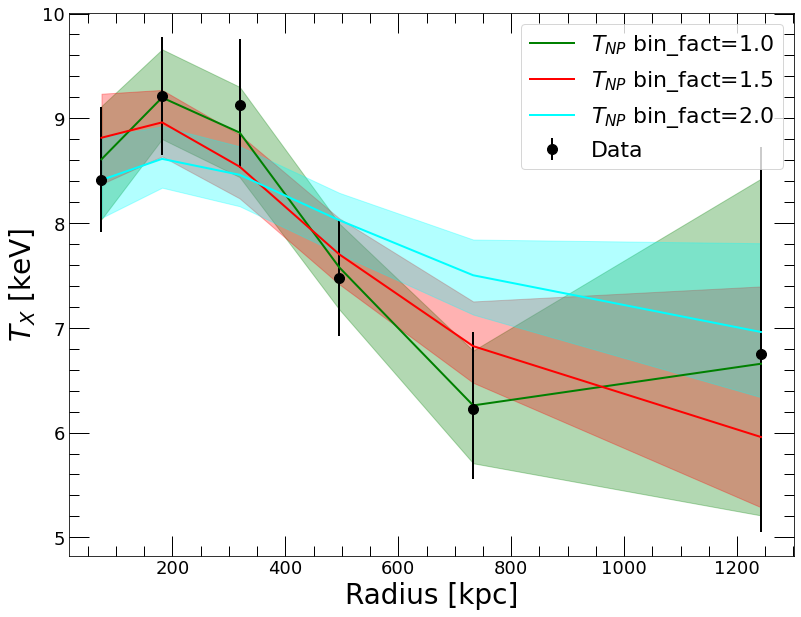

In [17]:
plt.clf()

plt.xlabel('Radius [kpc]')
plt.ylabel('$T_{X}$ [keV]')

plt.errorbar(spec_data.rref_x,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),
             fmt='o',color='black', markersize=10, label='Data')

plt.plot(spec_data.rref_x,mhydNP.ktmod,color='green', label='$T_{NP}$ bin_fact=1.0')
plt.fill_between(spec_data.rref_x, mhydNP.ktmod_lo, mhydNP.ktmod_hi, color='green', alpha=0.3)

plt.plot(spec_data.rref_x,NP_15.ktmod,color='red', label='$T_{NP}$ bin_fact=1.5')
plt.fill_between(spec_data.rref_x, NP_15.ktmod_lo, NP_15.ktmod_hi, color='red', alpha=0.3)

plt.plot(spec_data.rref_x,NP_2.ktmod,color='cyan', label='$T_{NP}$ bin_fact=2.0')
plt.fill_between(spec_data.rref_x, NP_2.ktmod_lo, NP_2.ktmod_hi, color='cyan', alpha=0.3)

plt.legend(fontsize=22)


The impact of the smoothing scale on the temperature profile is very clear. While the minimal smoothing is probably a good choice to investigate the shape of the thermodynamic profiles, the variations in the temperature gradient are too large to allow a reasonable estimate of the hydrostatic mass profile. Conversely, a binning factor of 2.0 provides a smooth temperature profile with a good control over the gradient, but misses out on obvious fluctuations. The latter profile is thus more appropriate to determine the shape of the mass profile.

We can use the [hydromass.prof_GP_hires](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.nonparametric.prof_GP_hires) function to check how the recovered entropy profiles depend on the choice of the smoothing scale,

In [18]:
profiles_15 = hydromass.prof_GP_hires(Mhyd=NP_15,
                                          npt=200,
                                          rin=40.,
                                          Z=0.3)

profiles_2 = hydromass.prof_GP_hires(Mhyd=NP_2,
                                          npt=200,
                                          rin=40.,
                                          Z=0.3)

<Figure size 936x720 with 0 Axes>

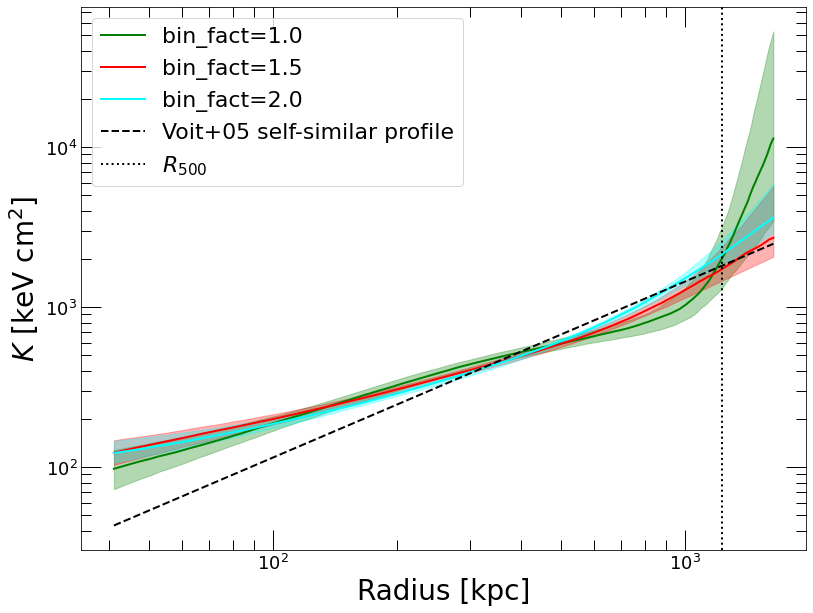

In [19]:
plt.clf()

fig = plt.figure()
ax = fig.add_subplot()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('$K$ [keV cm$^{2}$]')
    
plt.plot(thermo_profiles['R_REF'], thermo_profiles['K'], color='green', label='bin_fact=1.0')
plt.fill_between(thermo_profiles['R_REF'], thermo_profiles['K_LO'], thermo_profiles['K_HI'], color='green', alpha=0.3)

plt.plot(profiles_15['R_REF'], profiles_15['K'], color='red', label='bin_fact=1.5')
plt.fill_between(profiles_15['R_REF'], profiles_15['K_LO'], profiles_15['K_HI'], color='red', alpha=0.3)

plt.plot(profiles_2['R_REF'], profiles_2['K'], color='cyan', label='bin_fact=2.0')
plt.fill_between(profiles_2['R_REF'], profiles_2['K_LO'], profiles_2['K_HI'], color='cyan', alpha=0.3)


M500 = 9.0387E+14 # NFW M500 in Solar mass for this system
R500 = 1230 # NFW R500 in kpc
eofz=pyproffit.cosmo.efunc(z_m0451) # E(z)
K500=1667.*np.power(M500/1e15,2./3.)*np.power(eofz,-2./3.) # Self-similar K500

Kmod = 1.42 * K500 * (thermo_profiles['R_REF']/R500) ** 1.1
plt.plot(thermo_profiles['R_REF'], Kmod, '--', color='black', label='Voit+05 self-similar profile')

ylim = ax.get_ylim()
xlim = ax.get_xlim()

plt.plot([R500, R500], ylim, ':', color='black', label='$R_{500}$')

plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])

plt.legend(fontsize=22)



## Non-parametric mass profile ##

The reconstructed 3D gas density and temperature profiles can be combined to determine the hydrostatic mass profile in a non-parametric way,

$$ M(<r) = \frac{rkT}{G\mu m_p}\left( \frac{\partial \log T}{\partial log r} + \frac{\partial \log n_e}{\partial \log r}\right)$$

Since the basis functions describing the profiles of $T$ and $n_e$ are analytical, their gradients can be computed analytically.

The [hydromass.mass_GP_from_samples](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.nonparametric.mass_GP_from_samples) function allows the user to compute the hydrostatic mass profile from a loaded non-parametric reconstruction. The task also computes the corresponding gas mass and gras fraction profiles. Here we apply this tool to the three loaded Mhyd objects,

In [20]:
mass_NP_def = hydromass.mass_GP_from_samples(mhydNP)

mass_NP_2 = hydromass.mass_GP_from_samples(NP_2)

mass_NP_15 = hydromass.mass_GP_from_samples(NP_15)


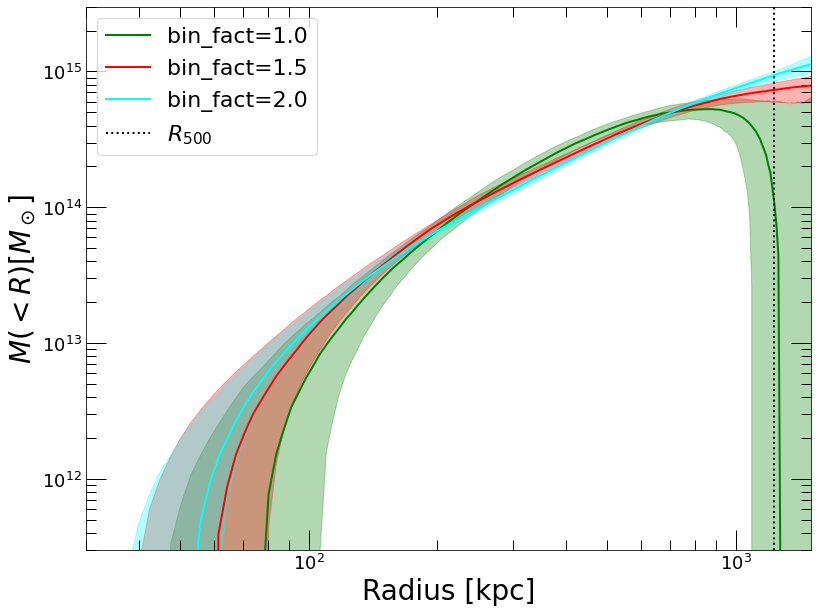

In [21]:
plt.clf()

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('$M(<R) [M_\odot]$')

plt.plot(mass_NP_def['R_OUT'], mass_NP_def['MASS'], color='green', label='bin_fact=1.0')
plt.fill_between(mass_NP_def['R_OUT'], mass_NP_def['MASS_LO'], mass_NP_def['MASS_HI'], color='green', alpha=0.3)

plt.plot(mass_NP_15['R_OUT'], mass_NP_15['MASS'], color='red', label='bin_fact=1.5')
plt.fill_between(mass_NP_15['R_OUT'], mass_NP_15['MASS_LO'], mass_NP_15['MASS_HI'], color='red', alpha=0.3)

plt.plot(mass_NP_2['R_OUT'], mass_NP_2['MASS'], color='cyan', label='bin_fact=2.0')
plt.fill_between(mass_NP_2['R_OUT'], mass_NP_2['MASS_LO'], mass_NP_2['MASS_HI'], color='cyan', alpha=0.3)

plt.axis([30., 1500., 3e11, 3e15])

plt.plot([R500, R500], [3e11, 3e15], ':', color='black', label='$R_{500}$')

plt.legend(fontsize=22)


Clearly the minimal smoothing is insufficient to recover a meaningful mass profile. Conversely, the run with _bin_fact_=2.0 provides a nice reconstruction of the mass profile with minimal assumptions on the properties of the data.

We can then compare the non-parametric reconstruction to the NFW fit obtained in [the tutorial on mass profiles](https://hydromass.readthedocs.io/en/latest/Mass_model.html), which can be easily reloaded using the [hydromass.ReloadModel](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.save.ReloadModel) function,

In [22]:
m_nfw = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451)

mod_nfw = hydromass.ReloadModel(Mhyd=m_nfw, infile='mhyd/test_save.fits')

mass_nfw = hydromass.mass_from_samples(Mhyd=m_nfw, model=mod_nfw)

No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


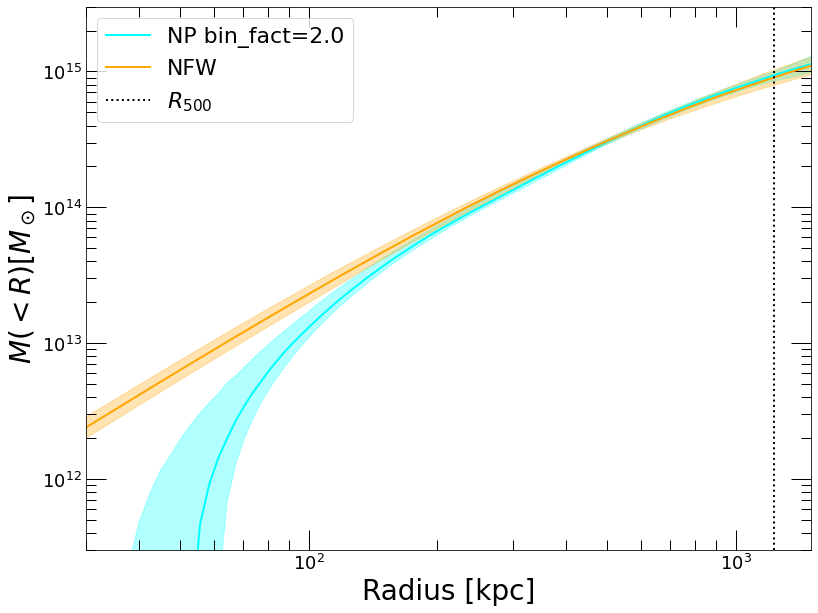

In [23]:
plt.clf()

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('$M(<R) [M_\odot]$')

plt.plot(mass_NP_2['R_OUT'], mass_NP_2['MASS'], color='cyan', label='NP bin_fact=2.0')
plt.fill_between(mass_NP_2['R_OUT'], mass_NP_2['MASS_LO'], mass_NP_2['MASS_HI'], color='cyan', alpha=0.3)

plt.plot(mass_nfw['R_OUT'], mass_nfw['MASS'], color='orange', label='NFW')
plt.fill_between(mass_nfw['R_OUT'], mass_nfw['MASS_LO'], mass_nfw['MASS_HI'], color='orange', alpha=0.3)

plt.axis([30., 1500., 3e11, 3e15])

plt.plot([R500, R500], [3e11, 3e15], ':', color='black', label='$R_{500}$')

plt.legend(fontsize=22)


The mass profile is very similar to an NFW beyond ~100 kpc but shows a flat core in the innermost regions.

## Taking variations of emissivity into account ##

In all the previous runs the conversion factor from count rate to emissivity was assumed to be constant over the radial range. While for hot clusters observed in the soft X-ray range this is usually a very good assumption, in galaxy groups with temperatures of 2 keV and below, the emissivity can depend substantially on the local gas temperature and metallicity.

The non-parametric temperature reconstruction allows us to compute a conversion profile which will be interpolated and taken into account in the gas density reconstruction. This can be done by calculating the emissivity conversion on a grid of temperature values,

In [ ]:
ccfprof = np.empty(p2.nbin)
kt3d = np.interp(p2.bins*mhydNP.amin2kpc, thermo_profiles['R_REF'], thermo_profiles['T3D'])

for i in range(p2.nbin):
    ccfprof[i] = hydromass.calc_emissivity(cosmo=pyproffit.cosmo, z=z_m0451, nh=nh_m0451, kt=kt3d[i], 
                                                elow=0.7, ehigh=1.2, rmf=rsp)

We can now pass the emissivity conversion profile to an Mhyd object, here the reloaded NFW profile, and apply again the reconstruction,

In [25]:
m_nfw.ccf = ccfprof

m_nfw.run(model=mod_nfw, nmcmc=100, tune=100)

Interpolating conversion factor profile onto the radial grid
Estimated value of P0: 0.000535329
coefs -187.90419872441586
cdelta_interval__ -1.0833801859728536
rdelta_interval__ -0.9384616845706304
logp0_interval__ -1.2303705795943694
Running HMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 16100
Interrupted at 16,099 [8%]: Average Loss = 257.09
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 22 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  0.6431475003560384  minutes


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
